In [1]:
import pandas as pd
import numpy as np
from pandas import DataFrame as DF
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder,LabelEncoder,OrdinalEncoder,PowerTransformer,StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV,KFold
from sklearn.feature_selection import RFECV
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error as mse
pd.set_option('display.max_columns',None)
from warnings import filterwarnings
filterwarnings('ignore')
from scipy.stats import chi2_contingency,chisquare
from xverse.transformer import WOE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier 
from sklearn.metrics import ConfusionMatrixDisplay,classification_report
sns.set_color_codes=True
plt.rcParams['figure.facecolor']='papayawhip'
plt.rcParams['figure.figsize']=(10,7)
%matplotlib inline

.style.background_gradient('Greens')

In [2]:
event = pd.read_excel('Events_HolidaysData.xlsx')
print(event.shape)
event.head()

(150, 4)


,Year,MonthDate,Event,DayCategory
0,2009,2001-01-01,New Year's Day,Federal Holiday
1,2009,2019-01-01,Martin Luther King Jr. Day,Federal Holiday
2,2009,2014-02-01,Valentine's Day,Event
3,2009,2016-02-01,Presidents' Day,Federal Holiday
4,2009,2012-04-01,Easter Sunday,Event


In [3]:
eco = pd.read_excel('macro_economic.xlsx')
print(eco.shape)
eco.head()

(96, 18)


,Year-Month,Monthly Nominal GDP Index (inMillion$),Monthly Real GDP Index (inMillion$),CPI,PartyInPower,unemployment rate,CommercialBankInterestRateonCreditCardPlans,"Finance Rate on Personal Loans at Commercial Banks, 24 Month Loan",Earnings or wages in dollars per hour,AdvertisingExpenses (in Thousand Dollars),Cotton Monthly Price - US cents per Pound(lbs),Change(in%),Average upland planted(million acres),Average upland harvested(million acres),yieldperharvested acre,Production (in 480-lb netweright in million bales),Mill use (in 480-lb netweright in million bales),Exports
0,2009 - Jan,14421.752895,14407.053343,233.402,Democrats,7.8,12.03,11.44,22.05,137,57.70,4.02,9.296,7.559,799,12.589,4.17,11.550
1,2009 - Feb,14389.200466,14366.176571,234.663,Democrats,8.3,12.97,11.05,22.22,200,55.21,-4.32,9.296,7.559,799,12.589,3.87,11.100
2,2009 - Mar,14340.701639,14351.786822,235.067,Democrats,8.7,12.97,11.05,22.22,?,51.50,-6.72,9.296,7.559,799,12.589,3.72,11.650
3,2009 - Apr,14326.815525,14351.601731,235.582,Democrats,9.0,12.97,11.05,22.13,214,56.78,10.25,9.296,7.559,787,12.400,3.62,12.225
4,2009 - May,14345.904809,14368.123959,235.975,Democrats,9.4,13.32,11.25,22.04,?,61.95,9.11,9.297,7.400,803,12.384,3.52,12.300


In [4]:
train = pd.read_csv('train.csv')
print(train.shape)
train.head()

(180, 4)


,Year,Month,ProductCategory,Sales(In ThousandDollars)
0,2009,1,WomenClothing,1755.0
1,2009,1,MenClothing,524.0
2,2009,1,OtherClothing,936.0
3,2009,2,WomenClothing,1729.0
4,2009,2,MenClothing,496.0


## Weather DataSet

In [5]:
wd = {}
for i in range(2009,2017):
    wd[f'climate_{i}'] = pd.read_excel('WeatherData.xlsx',sheet_name=str(i),na_values={'WeatherEvent':'NormalDay'})
    
print(wd.keys(),wd['climate_2010'].shape)

dict_keys(['climate_2009', 'climate_2010', 'climate_2011', 'climate_2012', 'climate_2013', 'climate_2014', 'climate_2015', 'climate_2016']) (365, 23)


In [6]:
wd['climate_2010'].head()

,Year,Month,Day,Temp high (°C),Temp avg (°C),Temp low (°C),Dew Point high (°C),Dew Point avg (°C),Dew Point low (°C),Humidity (%) high,Humidity (%) avg,Humidity (%) low,Sea Level Press. (hPa) high,Sea Level Press. (hPa) avg,Sea Level Press. (hPa) low,Visibility (km) high,Visibility (km) avg,Visibility (km) low,Wind (km/h) low,Wind (km/h) avg,Wind (km/h) high,Precip. (mm) sum,WeatherEvent
0,2009,Jan,1,4,3,1,1,0,-3,100,85,70,1016,1012,1006,16,10,3,26,5,35,0.76,Snow
1,2009,Jan,2,1,-3,-8,-4,-10,-16,85,68,50,1006,1005,1003,16,14,2,35,20,56,0.51,Snow
2,2009,Jan,3,-6,-7,-8,-12,-14,-16,67,56,45,1004,1000,998,16,15,3,42,23,63,T,Snow
3,2009,Jan,4,-1,-4,-7,-11,-12,-13,62,53,43,1007,1006,1004,16,16,16,27,17,39,0,NaN
4,2009,Jan,5,-1,-4,-7,-10,-11,-13,65,56,47,1007,1006,1005,16,16,16,27,16,39,T,NaN


## column Renaming

In [7]:
d = {}
c = ['Year','Month','Day','Temp high (°C)','Temp avg (°C)','Temp low (°C)','Dew Point high (°C)','Dew Point avg (°C)','Dew Point low (°C)','Humidity\xa0(%) high','Humidity\xa0(%) avg','Humidity\xa0(%) low','Sea Level Press.\xa0(hPa) high','Sea Level Press.\xa0(hPa) avg','Sea Level Press.\xa0(hPa) low','Visibility\xa0(km) high','Visibility\xa0(km) avg','Visibility\xa0(km) low','Wind\xa0(km/h) low','Wind\xa0(km/h) avg','Wind\xa0(km/h) high','Precip.\xa0(mm) sum','WeatherEvent']
o = ['Year', 'Month', 'Day', 'Temp high (°C)', 'Temp avg (°C)','Temp low (°C)', 'Dew Point high (°C)', 'Dew Point avg (°C)','Dew Point low (°C)', 'Humidity (%) high', 'Humidity (%) avg','Humidity (%) low', 'Sea Level Press. (hPa) high','Sea Level Press. (hPa) avg', 'Sea Level Press. (hPa) low','Visibility (km) high', 'Visibility (km) avg', 'Visibility (km) low','Wind (km/h) low', 'Wind (km/h) avg', 'Wind (km/h) high','Precip. (mm) sum', 'WeatherEvent']
for i,j in zip(c,o):
    d[i] = j

## Treating Missing Values in weather data

In [8]:
for i in wd.keys():
    wd[i].rename(d,axis=1,inplace=True)
    for c in o[3:-1]:
        wd[i][c].replace({'-':np.nan,'T':np.nan},inplace=True)
        wd[i][c].ffill(inplace=True)
        wd[i][c] = wd[i][c].astype('int64')
    wd[i]['Precip. (mm) sum'].replace({'T':np.nan,'-':np.nan},inplace=True)
    wd[i]['Precip. (mm) sum'].ffill(inplace=True)
    wd[i]['Precip. (mm) sum'] = wd[i]['Precip. (mm) sum'].astype('int64')

## Encoding Month,and Pivot_table

In [9]:
wpt = {}
m_d = {'Apr':4, 'Aug':8, 'Dec':12, 'Feb':2, 'Jan':1, 'Jul':7, 'Jun':6, 'Mar':3, 'May':5,'Nov':11, 'Oct':10, 'Sep':9}
for d in wd.keys():
    wpt[d] = pd.pivot_table(index=['Year','Month'],values=[ 'Temp high (°C)', 'Temp avg (°C)','Temp low (°C)', 'Dew Point high (°C)', 'Dew Point avg (°C)','Dew Point low (°C)', 'Humidity (%) high', 'Humidity (%) avg','Humidity (%) low', 'Sea Level Press. (hPa) high','Sea Level Press. (hPa) avg', 'Sea Level Press. (hPa) low','Visibility (km) high', 'Visibility (km) avg', 'Visibility (km) low','Wind (km/h) low', 'Wind (km/h) avg', 'Wind (km/h) high','Precip. (mm) sum'],data = wd[d])
    wpt[d].reset_index(inplace=True)
    wpt[d]['Month'].replace(m_d,inplace=True)
for i in wpt:
    print(wpt[i].shape)

(12, 21)
(12, 21)
(12, 21)
(12, 21)
(12, 21)
(12, 21)
(12, 21)
(12, 21)


In [10]:
wpt['climate_2014']

,Year,Month,Dew Point avg (°C),Dew Point high (°C),Dew Point low (°C),Humidity (%) avg,Humidity (%) high,Humidity (%) low,Precip. (mm) sum,Sea Level Press. (hPa) avg,Sea Level Press. (hPa) high,Sea Level Press. (hPa) low,Temp avg (°C),Temp high (°C),Temp low (°C),Visibility (km) avg,Visibility (km) high,Visibility (km) low,Wind (km/h) avg,Wind (km/h) high,Wind (km/h) low
0,2009,4,0.566667,4.800000,-3.966667,53.533333,73.066667,33.566667,2.433333,1016.766667,1021.400000,1012.433333,11.466667,16.233333,6.266667,14.700000,16.000000,11.900000,10.133333,38.933333,24.666667
1,2009,8,14.451613,16.806452,11.709677,60.354839,77.548387,42.548387,1.193548,1016.741935,1018.677419,1014.838710,23.612903,27.903226,19.064516,15.064516,16.000000,12.161290,6.000000,29.580645,17.774194
2,2009,12,-1.225806,1.838710,-4.774194,64.709677,77.451613,51.548387,4.774194,1019.419355,1023.548387,1015.483871,5.225806,7.741935,2.516129,13.193548,15.677419,9.612903,10.838710,37.451613,24.129032
3,2009,2,-7.821429,-4.178571,-11.678571,58.714286,74.892857,42.035714,4.785714,1016.964286,1022.321429,1011.964286,0.285714,3.285714,-3.107143,12.357143,15.750000,8.535714,10.250000,40.928571,25.178571
4,2009,1,-9.400000,-5.166667,-13.833333,59.433333,75.033333,43.900000,1.866667,1016.400000,1021.300000,1011.033333,-1.766667,1.733333,-5.700000,13.866667,15.900000,10.633333,9.966667,37.866667,18.700000
5,2009,7,16.451613,18.838710,13.451613,63.967742,80.935484,46.483871,5.451613,1014.677419,1017.258065,1012.161290,24.677419,28.548387,20.483871,13.967742,15.645161,10.483871,11.709677,36.516129,23.645161
6,2009,6,13.866667,16.466667,10.833333,62.600000,79.833333,44.866667,3.500000,1015.866667,1018.400000,1013.433333,22.400000,26.700000,17.800000,13.633333,15.933333,10.066667,6.633333,30.333333,18.700000
7,2009,3,-8.258065,-3.774194,-12.612903,47.322581,61.419355,32.935484,2.774194,1016.451613,1021.290323,1011.903226,2.806452,7.000000,-1.677419,14.774194,16.000000,12.032258,11.419355,41.967742,26.677419
8,2009,5,8.096774,11.645161,4.548387,59.967742,77.032258,42.387097,7.580645,1016.290323,1019.258065,1013.225806,17.612903,22.161290,12.806452,12.709677,15.741935,9.096774,7.290323,35.225806,22.064516
9,2009,11,-1.766667,2.633333,-5.600000,54.866667,70.733333,38.700000,3.700000,1016.800000,1021.200000,1012.266667,7.533333,10.966667,3.866667,14.266667,16.000000,11.066667,8.800000,38.233333,23.200000


## Treating the Typo of year col

In [11]:
for i in list(wpt.keys())[:-3]:
    wpt[i]['Year'] = int(i[-4:])

## Concating all Weather Sheets

In [12]:
wf = DF()
for i in list(wpt.keys())[:-3]:
    wf = pd.concat([wf,wpt[i]],axis=0,ignore_index=True)
wf.head(20)

,Year,Month,Dew Point avg (°C),Dew Point high (°C),Dew Point low (°C),Humidity (%) avg,Humidity (%) high,Humidity (%) low,Precip. (mm) sum,Sea Level Press. (hPa) avg,Sea Level Press. (hPa) high,Sea Level Press. (hPa) low,Temp avg (°C),Temp high (°C),Temp low (°C),Visibility (km) avg,Visibility (km) high,Visibility (km) low,Wind (km/h) avg,Wind (km/h) high,Wind (km/h) low
0,2009,4,2.533333,6.233333,-1.200000,55.700000,75.466667,35.733333,3.900000,1014.533333,1018.833333,1010.433333,12.733333,17.100000,7.833333,14.066667,15.900000,10.866667,11.366667,39.566667,27.300000
1,2009,8,18.483871,20.451613,16.129032,72.483871,88.870968,55.677419,3.677419,1015.967742,1018.225806,1013.387097,24.387097,27.967742,20.548387,14.483871,16.000000,9.903226,6.806452,28.064516,19.290323
2,2009,12,-4.677419,-0.935484,-8.709677,61.741935,77.612903,45.258065,5.806452,1017.225806,1022.483871,1012.193548,2.354839,5.451613,-1.032258,13.774194,16.000000,10.677419,13.451613,42.838710,28.580645
3,2009,2,-6.392857,-2.464286,-10.571429,54.000000,69.535714,38.107143,0.714286,1017.071429,1021.714286,1012.464286,2.785714,6.964286,-1.642857,15.178571,16.000000,13.285714,12.214286,41.642857,27.928571
4,2009,1,-9.903226,-6.096774,-14.000000,57.354839,71.774194,42.322581,2.322581,1015.967742,1021.290323,1010.516129,-2.096774,0.741935,-5.322581,14.000000,16.000000,11.451613,12.000000,39.322581,27.000000
5,2009,7,16.451613,18.838710,13.612903,70.806452,88.612903,52.483871,5.645161,1013.580645,1015.903226,1011.193548,22.741935,26.838710,18.225806,12.935484,16.000000,8.451613,7.903226,31.935484,21.612903
6,2009,6,15.366667,17.100000,13.133333,78.866667,95.200000,61.633333,8.933333,1011.166667,1013.300000,1008.733333,19.866667,23.666667,15.833333,11.833333,15.900000,5.933333,7.300000,31.300000,21.533333
7,2009,3,-2.903226,0.258065,-6.741935,57.064516,74.096774,39.548387,1.322581,1021.064516,1025.096774,1017.032258,5.967742,9.838710,1.774194,14.258065,16.000000,10.677419,11.387097,38.612903,27.000000
8,2009,5,10.096774,12.967742,6.516129,68.516129,85.645161,50.935484,4.000000,1017.161290,1020.419355,1014.129032,17.000000,21.354839,12.483871,12.451613,15.903226,9.000000,8.129032,33.096774,23.000000
9,2009,11,4.166667,7.000000,1.433333,66.600000,80.466667,52.233333,1.200000,1019.033333,1022.266667,1015.633333,10.800000,13.733333,7.566667,14.666667,16.000000,11.833333,11.133333,36.733333,25.866667


In [13]:
wf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Year                         60 non-null     int64  
 1   Month                        60 non-null     int64  
 2   Dew Point avg (°C)           60 non-null     float64
 3   Dew Point high (°C)          60 non-null     float64
 4   Dew Point low (°C)           60 non-null     float64
 5   Humidity (%) avg             60 non-null     float64
 6   Humidity (%) high            60 non-null     float64
 7   Humidity (%) low             60 non-null     float64
 8   Precip. (mm) sum             60 non-null     float64
 9   Sea Level Press. (hPa) avg   60 non-null     float64
 10  Sea Level Press. (hPa) high  60 non-null     float64
 11  Sea Level Press. (hPa) low   60 non-null     float64
 12  Temp avg (°C)                60 non-null     float64
 13  Temp high (°C)        

In [14]:
train.head()

,Year,Month,ProductCategory,Sales(In ThousandDollars)
0,2009,1,WomenClothing,1755.0
1,2009,1,MenClothing,524.0
2,2009,1,OtherClothing,936.0
3,2009,2,WomenClothing,1729.0
4,2009,2,MenClothing,496.0


In [15]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 4 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Year                       180 non-null    int64  
 1   Month                      180 non-null    int64  
 2   ProductCategory            180 non-null    object 
 3   Sales(In ThousandDollars)  170 non-null    float64
dtypes: float64(1), int64(2), object(1)
memory usage: 5.8+ KB


In [16]:
# dropping null value of Target Variable
train.dropna(inplace=True)
train.reset_index(drop=True,inplace=True)
train.shape

(170, 4)

In [17]:
#Pivoting Train data w.r.t Year and Month
train_pt = pd.pivot_table(index=['Year','Month'],columns='ProductCategory',data=train)
train_pt.reset_index(inplace=True)
train_pt

Year Month Sales(In ThousandDollars)                \
ProductCategory                           MenClothing OtherClothing   
0                2009     1                     524.0         936.0   
1                2009     2                     496.0         859.0   
2                2009     3                     542.0         921.0   
3                2009     4                     669.0         914.0   
4                2009     5                     650.0         989.0   
5                2009     6                     607.0         932.0   
6                2009     7                     575.0         901.0   
7                2009     8                     551.0         865.0   
8                2009     9                     579.0         819.0   
9                2009    10                     610.0         914.0   
10               2009    11                     620.0         955.0   
11               2009    12                     930.0        1351.0   
12               2010     1                     476.0         945.0   
13               2010     2                     471.0         869.0   
14               2010     3                     568.0         941.0   
15               2010     4                     630.0           NaN   
16               2010     5                     627.0         991.0   
17               2010     6                     598.0         984.0   
18               2010     7                     544.0         937.0   
19               2010     8                       NaN         897.0   
20               2010     9                     563.0         839.0   
21               2010    10                     634.0         930.0   
22               2010    11                     669.0        1035.0   
23               2010    12                     988.0        1398.0   
24               2011     1                     487.0         968.0   
25               2011     2                     497.0         878.0   
26               2011     3                     599.0        1064.0   
27               2011     4                     690.0         985.0   
28               2011     5                     677.0        1027.0   
29               2011     6                       NaN           NaN   
30               2011     7                     587.0         985.0   
31               2011     8                     549.0        1001.0   
32               2011     9                     643.0         930.0   
33               2011    10                     682.0        1020.0   
34               2011    11                     707.0        1147.0   
35               2011    12                    1081.0        1596.0   
36               2012     1                     525.0        1039.0   
37               2012     2                     545.0           NaN   
38               2012     3                     623.0        1229.0   
39               2012     4                     711.0        1136.0   
40               2012     5                     725.0        1155.0   
41               2012     6                     703.0        1205.0   
42               2012     7                     613.0        1049.0   
43               2012     8                       NaN        1124.0   
44               2012     9                     687.0        1045.0   
45               2012    10                     710.0        1158.0   
46               2012    11                     731.0        1252.0   
47               2012    12                    1080.0        1475.0   
48               2013     1                     599.0        1036.0   
49               2013     2                     560.0        1144.0   
50               2013     3                     682.0        1346.0   
51               2013     4                     718.0        1188.0   
52               2013     5                     749.0        1194.0   
53               2013     6                     678.0        1261.0   
54               2013     7              

In [18]:
train_pt.dropna(inplace=True)
train_pt.reset_index(drop=True,inplace=True)
train_pt.shape

(52, 5)

## Merge Train and Weather on Year & Month

In [19]:
train_pt = pd.merge(wf,train_pt,on=['Year','Month'],how='inner',sort=True,copy=True)
print(train_pt.shape)
train_pt.head()

(52, 24)


,Year,Month,Dew Point avg (°C),Dew Point high (°C),Dew Point low (°C),Humidity (%) avg,Humidity (%) high,Humidity (%) low,Precip. (mm) sum,Sea Level Press. (hPa) avg,Sea Level Press. (hPa) high,Sea Level Press. (hPa) low,Temp avg (°C),Temp high (°C),Temp low (°C),Visibility (km) avg,Visibility (km) high,Visibility (km) low,Wind (km/h) avg,Wind (km/h) high,Wind (km/h) low,"(Sales(In ThousandDollars), MenClothing)","(Sales(In ThousandDollars), OtherClothing)","(Sales(In ThousandDollars), WomenClothing)"
0,2009,1,-9.903226,-6.096774,-14.000000,57.354839,71.774194,42.322581,2.322581,1015.967742,1021.290323,1010.516129,-2.096774,0.741935,-5.322581,14.000000,16.000000,11.451613,12.000000,39.322581,27.000000,524.0,936.0,1755.0
1,2009,2,-6.392857,-2.464286,-10.571429,54.000000,69.535714,38.107143,0.714286,1017.071429,1021.714286,1012.464286,2.785714,6.964286,-1.642857,15.178571,16.000000,13.285714,12.214286,41.642857,27.928571,496.0,859.0,1729.0
2,2009,3,-2.903226,0.258065,-6.741935,57.064516,74.096774,39.548387,1.322581,1021.064516,1025.096774,1017.032258,5.967742,9.838710,1.774194,14.258065,16.000000,10.677419,11.387097,38.612903,27.000000,542.0,921.0,2256.0
3,2009,4,2.533333,6.233333,-1.200000,55.700000,75.466667,35.733333,3.900000,1014.533333,1018.833333,1010.433333,12.733333,17.100000,7.833333,14.066667,15.900000,10.866667,11.366667,39.566667,27.300000,669.0,914.0,2662.0
4,2009,5,10.096774,12.967742,6.516129,68.516129,85.645161,50.935484,4.000000,1017.161290,1020.419355,1014.129032,17.000000,21.354839,12.483871,12.451613,15.903226,9.000000,8.129032,33.096774,23.000000,650.0,989.0,2732.0


In [20]:
train_pt.iloc[:,3:-3].skew()

Dew Point high (°C)           -0.004365
Dew Point low (°C)             0.084320
Humidity (%) avg               0.377539
Humidity (%) high              0.197507
Humidity (%) low               0.329874
Precip. (mm) sum               2.093410
Sea Level Press. (hPa) avg    -0.086000
Sea Level Press. (hPa) high    0.005066
Sea Level Press. (hPa) low    -0.306628
Temp avg (°C)                  0.036962
Temp high (°C)                -0.000682
Temp low (°C)                  0.079103
Visibility (km) avg           -0.448531
Visibility (km) high          -1.135855
Visibility (km) low           -0.438851
Wind (km/h) avg                0.153260
Wind (km/h) high              -0.013276
Wind (km/h) low                0.013726
dtype: float64

In [21]:
t_yg = train_pt.groupby('Year')

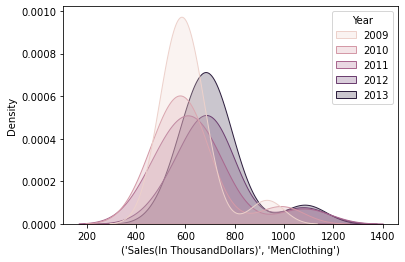

In [22]:
sns.kdeplot(x=train_pt[('Sales(In ThousandDollars)', 'MenClothing')],hue = train_pt['Year'],fill=True);

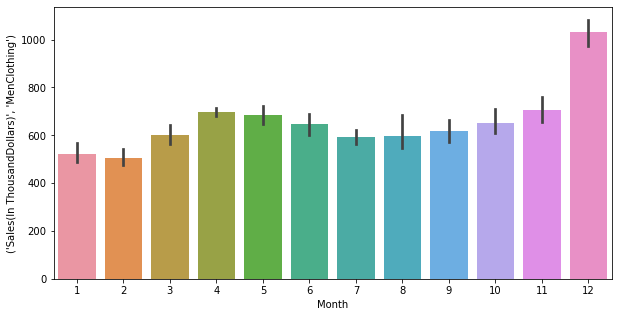

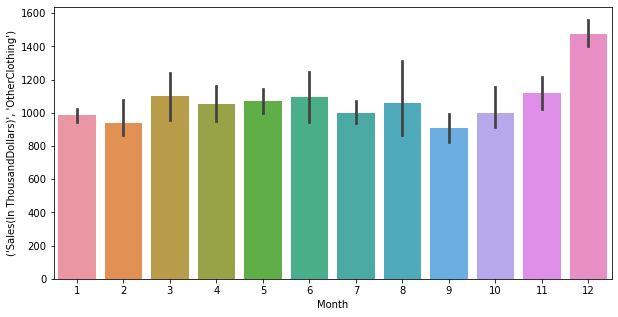

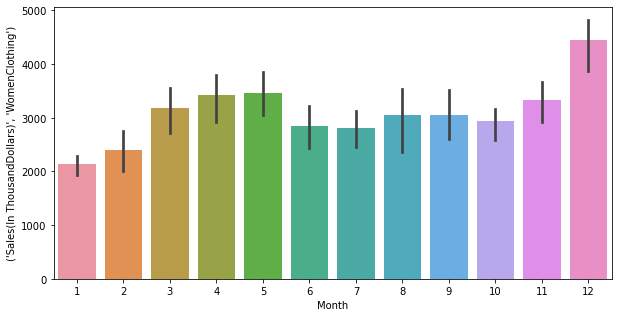

In [23]:
for i in [  ('Sales(In ThousandDollars)', 'MenClothing'),('Sales(In ThousandDollars)', 'OtherClothing'),('Sales(In ThousandDollars)', 'WomenClothing')]:
    plt.figure(figsize=(10,5))
    sns.barplot(x='Month',y=i,data=train_pt);

In [24]:
pd.pivot_table(index='Month',values=[  ('Sales(In ThousandDollars)', 'MenClothing'),
       ('Sales(In ThousandDollars)', 'OtherClothing'),
       ('Sales(In ThousandDollars)', 'WomenClothing')],data=train_pt).describe().style.background_gradient('Greens')

,"('Sales(In ThousandDollars)', 'MenClothing')","('Sales(In ThousandDollars)', 'OtherClothing')","('Sales(In ThousandDollars)', 'WomenClothing')"
count,12.000000,12.000000,12.000000
mean,654.566667,1067.397222,3090.437500
std,134.629315,144.908160,577.695833
min,506.000000,907.750000,2139.400000
25%,595.100000,995.900000,2841.925000
50%,631.500000,1057.375000,3056.083333
75%,688.450000,1096.675000,3358.387500
max,1032.800000,1477.200000,4442.800000


def sale_m(x):
    if x<595.1:
        return 'Low'
    elif x>=595.1 and x<684.55:
        return 'Medium'
    else :
        return 'High'

    
def sale_o(x):
    if x<996:
        return 'Low'
    elif x>=996 and x<1096.67:
        return 'Medium'
    else :
        return 'High'


def sale_f(x):
    if x<2898.40:
        return 'Low'
    elif x>=2898.40 and x<3358.38:
        return 'Medium'
    else :
        return 'High'

## Treating Skew

In [25]:
pt = PowerTransformer()
train_pt['Precip. (mm) sum'] = pt.fit_transform(train_pt[['Precip. (mm) sum']])
train_pt['Visibility (km) avg'] = pt.fit_transform(train_pt[['Visibility (km) avg']])
train_pt['Visibility (km) high'] = pt.fit_transform(train_pt[['Visibility (km) high']])

## spliting male,female,others

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]

In [26]:
train_m = train_pt.iloc[:,1:-2].copy()
train_o = train_pt.iloc[:,[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,22]].copy()
train_f = train_pt.iloc[:,[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,23]].copy()
print(train_f.shape,train_m.shape,train_o.shape)

(52, 21) (52, 21) (52, 21)


## encoding Month

train_f['Month'] = train_f.iloc[:,-1].apply(sale_f)
train_o['Month'] = train_o.iloc[:,-1].apply(sale_o)
train_m['Month'] = train_m.iloc[:,-1].apply(sale_m)

ohe_y = OneHotEncoder()
x = DF(ohe_y.fit_transform(train_pt[['Year']]).toarray(),columns=ohe_y.get_feature_names())

#from sklearn.linear_model import LinearRegression
print(len(mm))

ohe_m = OneHotEncoder()
mm = DF(ohe_m.fit_transform(train_m[['Month']]).toarray(),columns=ohe_m.get_feature_names())
mf = DF(ohe_m.transform(train_f[['Month']]).toarray(),columns=ohe_m.get_feature_names())
mo = DF(ohe_m.transform(train_o[['Month']]).toarray(),columns=ohe_m.get_feature_names())

X_m = pd.concat([mm,X_m],axis=1)
X_f = pd.concat([mf,X_f],axis=1)
X_o = pd.concat([mo,X_o],axis=1)
X_o.head()

In [27]:
X_f = train_f.iloc[:,1:-1].copy()
X_m = train_m.iloc[:,1:-1].copy()
X_o = train_o.iloc[:,1:-1].copy()
Y_f = train_f.iloc[:,-1].copy()
Y_m = train_m.iloc[:,-1].copy()
Y_o = train_o.iloc[:,-1].copy()

## Men sales model

In [28]:
xtrain,xtest,ytrain,ytest = train_test_split(X_m,Y_m,random_state=10,test_size=0.2)
xc = sm.add_constant(xtrain)
lrm = sm.OLS(ytrain,xc).fit()
lrm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         OLS Regression Results                                         
========================================================================================================
Dep. Variable:     ('Sales(In ThousandDollars)', 'MenClothing')   R-squared:                       0.641
Model:                                                      OLS   Adj. R-squared:                  0.316
Method:                                           Least Squares   F-statistic:                     1.972
Date:                                          Thu, 15 Sep 2022   Prob (F-statistic):             0.0668
Time:                                                  09:44:36   Log-Likelihood:                -237.69
No. Observations:                                            41   AIC:                             515.4
Df Residuals:                                                21   BIC:                             549.7
Df Model:                                                    19                                         
Covariance Type:                                      nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                       -1.118e+04   8771.428     -1.274      0.216   -2.94e+04    7062.386
Dew Point avg (°C)             63.3791    115.373      0.549      0.589    -176.553     303.311
Dew Point high (°C)            38.6630     85.220      0.454      0.655    -138.561     215.887
Dew Point low (°C)            -63.4958     89.601     -0.709      0.486    -249.831     122.840
Humidity (%) avg              963.5424    416.394      2.314      0.031      97.604    1829.480
Humidity (%) high            -486.0130    206.821     -2.350      0.029    -916.120     -55.906
Humidity (%) low             -468.6546    207.498     -2.259      0.035    -900.171     -37.138
Precip. (mm) sum               18.7484     29.136      0.643      0.527     -41.842      79.339
Sea Level Press. (hPa) avg   -171.7480    149.364     -1.150      0.263    -482.367     138.871
Sea Level Press. (hPa) high    75.1777     88.207      0.852      0.404    -108.259     258.615
Sea Level Press. (hPa) low    106.1979     71.220      1.491      0.151     -41.912     254.308
Temp avg (°C)                 343.6103    402.683      0.853      0.403    -493.815    1181.036
Temp high (°C)               -175.9411    201.534     -0.873      0.393    -595.053     243.171
Temp low (°C)                -205.6459    212.157     -0.969      0.343    -646.851     235.559
Visibility (km) avg           -36.6298     66.419     -0.551      0.587    -174.756     101.496
Visibility (km) high           -8.5491     37.521     -0.228      0.822     -86.579      69.480
Visibility (km) low            60.8128     43.493      1.398      0.177     -29.637     151.262
Wind (km/h) avg               -71.8575     45.463     -1.581      0.129    -166.404      22.689
Wind (km/h) high               52.7828     19.575      2.696      0.014      12.075      93.491
Wind (km/h) low               -17.7817     32.490     -0.547      0.590     -85.349      49.786
==============================================================================
Omnibus:                        1.622   Durbin-Watson:                   1.863
Prob(Omnibus):                  0.445   Jarque-Bera (JB):                0.942
Skew:                           0.359   Prob(JB):                        0.624
Kurtosis:                       3.191   Cond. No.                     8.90e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The conditi

In [29]:
ym_train_pred = lrm.predict(xc)
rmsetr = np.sqrt(mse(ytrain,ym_train_pred))
ym_test_pred = lrm.predict(sm.add_constant(xtest))
rmsets = np.sqrt(mse(ytest,ym_test_pred))
print((rmsetr+rmsets)/2,np.std([rmsetr,rmsets],ddof=1))

153.71287406969012 104.65322571389248


## Women sale Model

In [30]:
xtrain,xtest,ytrain,ytest = train_test_split(X_f,Y_f,random_state=10,test_size=0.2)
xc = sm.add_constant(xtrain)
lrf = sm.OLS(ytrain,xc).fit()
lrf.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                          OLS Regression Results                                          
==========================================================================================================
Dep. Variable:     ('Sales(In ThousandDollars)', 'WomenClothing')   R-squared:                       0.643
Model:                                                        OLS   Adj. R-squared:                  0.319
Method:                                             Least Squares   F-statistic:                     1.988
Date:                                            Thu, 15 Sep 2022   Prob (F-statistic):             0.0646
Time:                                                    09:44:36   Log-Likelihood:                -306.75
No. Observations:                                              41   AIC:                             653.5
Df Residuals:                                                  21   BIC:                             687.8
Df Model:                                                      19                                         
Covariance Type:                                        nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                       -8.564e+04   4.73e+04     -1.811      0.084   -1.84e+05    1.27e+04
Dew Point avg (°C)           -581.3221    621.805     -0.935      0.360   -1874.436     711.792
Dew Point high (°C)           280.0502    459.291      0.610      0.549    -675.098    1235.199
Dew Point low (°C)            123.2977    482.904      0.255      0.801    -880.956    1127.552
Humidity (%) avg             3233.5159   2244.153      1.441      0.164   -1433.456    7900.488
Humidity (%) high           -1586.9780   1114.660     -1.424      0.169   -3905.041     731.085
Humidity (%) low            -1580.6492   1118.313     -1.413      0.172   -3906.307     745.009
Precip. (mm) sum              311.5191    157.027      1.984      0.060     -15.036     638.074
Sea Level Press. (hPa) avg   -983.9766    804.996     -1.222      0.235   -2658.057     690.104
Sea Level Press. (hPa) high   506.1178    475.392      1.065      0.299    -482.515    1494.750
Sea Level Press. (hPa) low    555.4224    383.840      1.447      0.163    -242.817    1353.662
Temp avg (°C)                -481.0957   2170.261     -0.222      0.827   -4994.400    4032.209
Temp high (°C)                278.9322   1086.166      0.257      0.800   -1979.874    2537.738
Temp low (°C)                 378.3286   1143.421      0.331      0.744   -1999.546    2756.203
Visibility (km) avg            86.1782    357.966      0.241      0.812    -658.253     830.610
Visibility (km) high         -192.3930    202.220     -0.951      0.352    -612.933     228.147
Visibility (km) low           140.6750    234.408      0.600      0.555    -346.803     628.153
Wind (km/h) avg              -235.7207    245.025     -0.962      0.347    -745.277     273.836
Wind (km/h) high              200.5863    105.498      1.901      0.071     -18.810     419.982
Wind (km/h) low              -108.2349    175.107     -0.618      0.543    -472.391     255.921
==============================================================================
Omnibus:                        0.194   Durbin-Watson:                   1.965
Prob(Omnibus):                  0.907   Jarque-Bera (JB):                0.386
Skew:                           0.104   Prob(JB):                        0.824
Kurtosis:                       2.572   Cond. No.                     8.90e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly spec

In [31]:
yf_train_pred = lrm.predict(xc)
rmsetr = np.sqrt(mse(ytrain,yf_train_pred))
yf_test_pred = lrm.predict(sm.add_constant(xtest))
rmsets = np.sqrt(mse(ytest,yf_test_pred))
print((rmsetr+rmsets)/2,np.std([rmsetr,rmsets],ddof=1))

2610.7273441171264 137.64053535258972


## Others sales model

In [32]:
xtrain,xtest,ytrain,ytest = train_test_split(X_o,Y_o,random_state=10,test_size=0.2)
xc = sm.add_constant(xtrain)
lro = sm.OLS(ytrain,xc).fit()
lro.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                          OLS Regression Results                                          
==========================================================================================================
Dep. Variable:     ('Sales(In ThousandDollars)', 'OtherClothing')   R-squared:                       0.637
Model:                                                        OLS   Adj. R-squared:                  0.309
Method:                                             Least Squares   F-statistic:                     1.942
Date:                                            Thu, 15 Sep 2022   Prob (F-statistic):             0.0713
Time:                                                    09:44:36   Log-Likelihood:                -248.82
No. Observations:                                              41   AIC:                             537.6
Df Residuals:                                                  21   BIC:                             571.9
Df Model:                                                      19                                         
Covariance Type:                                        nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                       -1.516e+04   1.15e+04     -1.317      0.202   -3.91e+04    8773.815
Dew Point avg (°C)            -79.7628    151.360     -0.527      0.604    -394.533     235.008
Dew Point high (°C)            79.2457    111.801      0.709      0.486    -153.257     311.749
Dew Point low (°C)             40.8468    117.549      0.347      0.732    -203.609     285.303
Humidity (%) avg              741.3225    546.273      1.357      0.189    -394.714    1877.359
Humidity (%) high            -366.1140    271.331     -1.349      0.192    -930.378     198.150
Humidity (%) low             -383.7200    272.220     -1.410      0.173    -949.833     182.393
Precip. (mm) sum               27.3569     38.224      0.716      0.482     -52.133     106.847
Sea Level Press. (hPa) avg   -212.7921    195.952     -1.086      0.290    -620.298     194.713
Sea Level Press. (hPa) high    82.5218    115.720      0.713      0.484    -158.132     323.175
Sea Level Press. (hPa) low    146.3763     93.435      1.567      0.132     -47.932     340.684
Temp avg (°C)                  83.7002    528.286      0.158      0.876   -1014.931    1182.331
Temp high (°C)               -105.4084    264.395     -0.399      0.694    -655.248     444.431
Temp low (°C)                 -24.3514    278.332     -0.087      0.931    -603.175     554.472
Visibility (km) avg            -1.4557     87.136     -0.017      0.987    -182.666     179.754
Visibility (km) high          -22.5973     49.225     -0.459      0.651    -124.965      79.771
Visibility (km) low            14.2162     57.060      0.249      0.806    -104.446     132.878
Wind (km/h) avg               -86.7272     59.644     -1.454      0.161    -210.764      37.309
Wind (km/h) high               52.4530     25.680      2.043      0.054      -0.953     105.858
Wind (km/h) low               -20.8876     42.625     -0.490      0.629    -109.531      67.755
==============================================================================
Omnibus:                        0.130   Durbin-Watson:                   1.497
Prob(Omnibus):                  0.937   Jarque-Bera (JB):                0.120
Skew:                           0.104   Prob(JB):                        0.942
Kurtosis:                       2.836   Cond. No.                     8.90e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly spec

In [33]:
yo_train_pred = lrm.predict(xc)
rmsetr = np.sqrt(mse(ytrain,yo_train_pred))
yo_test_pred = lrm.predict(sm.add_constant(xtest))
rmsets = np.sqrt(mse(ytest,yo_test_pred))
print((rmsetr+rmsets)/2,np.std([rmsetr,rmsets],ddof=1))

487.9914683098501 72.69999113495169


## Test data

In [34]:
wpt['climate_2014'].head()

,Year,Month,Dew Point avg (°C),Dew Point high (°C),Dew Point low (°C),Humidity (%) avg,Humidity (%) high,Humidity (%) low,Precip. (mm) sum,Sea Level Press. (hPa) avg,Sea Level Press. (hPa) high,Sea Level Press. (hPa) low,Temp avg (°C),Temp high (°C),Temp low (°C),Visibility (km) avg,Visibility (km) high,Visibility (km) low,Wind (km/h) avg,Wind (km/h) high,Wind (km/h) low
0,2009,4,0.566667,4.800000,-3.966667,53.533333,73.066667,33.566667,2.433333,1016.766667,1021.400000,1012.433333,11.466667,16.233333,6.266667,14.700000,16.000000,11.900000,10.133333,38.933333,24.666667
1,2009,8,14.451613,16.806452,11.709677,60.354839,77.548387,42.548387,1.193548,1016.741935,1018.677419,1014.838710,23.612903,27.903226,19.064516,15.064516,16.000000,12.161290,6.000000,29.580645,17.774194
2,2009,12,-1.225806,1.838710,-4.774194,64.709677,77.451613,51.548387,4.774194,1019.419355,1023.548387,1015.483871,5.225806,7.741935,2.516129,13.193548,15.677419,9.612903,10.838710,37.451613,24.129032
3,2009,2,-7.821429,-4.178571,-11.678571,58.714286,74.892857,42.035714,4.785714,1016.964286,1022.321429,1011.964286,0.285714,3.285714,-3.107143,12.357143,15.750000,8.535714,10.250000,40.928571,25.178571
4,2009,1,-9.400000,-5.166667,-13.833333,59.433333,75.033333,43.900000,1.866667,1016.400000,1021.300000,1011.033333,-1.766667,1.733333,-5.700000,13.866667,15.900000,10.633333,9.966667,37.866667,18.700000


In [35]:
wpt['climate_2014'].sort_values(by='Month',inplace=True)
wpt['climate_2014'].reset_index(drop=True,inplace=True)
wpt['climate_2014'].head()

,Year,Month,Dew Point avg (°C),Dew Point high (°C),Dew Point low (°C),Humidity (%) avg,Humidity (%) high,Humidity (%) low,Precip. (mm) sum,Sea Level Press. (hPa) avg,Sea Level Press. (hPa) high,Sea Level Press. (hPa) low,Temp avg (°C),Temp high (°C),Temp low (°C),Visibility (km) avg,Visibility (km) high,Visibility (km) low,Wind (km/h) avg,Wind (km/h) high,Wind (km/h) low
0,2009,1,-9.400000,-5.166667,-13.833333,59.433333,75.033333,43.900000,1.866667,1016.400000,1021.300000,1011.033333,-1.766667,1.733333,-5.700000,13.866667,15.900000,10.633333,9.966667,37.866667,18.700000
1,2009,2,-7.821429,-4.178571,-11.678571,58.714286,74.892857,42.035714,4.785714,1016.964286,1022.321429,1011.964286,0.285714,3.285714,-3.107143,12.357143,15.750000,8.535714,10.250000,40.928571,25.178571
2,2009,3,-8.258065,-3.774194,-12.612903,47.322581,61.419355,32.935484,2.774194,1016.451613,1021.290323,1011.903226,2.806452,7.000000,-1.677419,14.774194,16.000000,12.032258,11.419355,41.967742,26.677419
3,2009,4,0.566667,4.800000,-3.966667,53.533333,73.066667,33.566667,2.433333,1016.766667,1021.400000,1012.433333,11.466667,16.233333,6.266667,14.700000,16.000000,11.900000,10.133333,38.933333,24.666667
4,2009,5,8.096774,11.645161,4.548387,59.967742,77.032258,42.387097,7.580645,1016.290323,1019.258065,1013.225806,17.612903,22.161290,12.806452,12.709677,15.741935,9.096774,7.290323,35.225806,22.064516


In [36]:
fc = wpt['climate_2014'].iloc[:,2:].copy()
fc.head()

,Dew Point avg (°C),Dew Point high (°C),Dew Point low (°C),Humidity (%) avg,Humidity (%) high,Humidity (%) low,Precip. (mm) sum,Sea Level Press. (hPa) avg,Sea Level Press. (hPa) high,Sea Level Press. (hPa) low,Temp avg (°C),Temp high (°C),Temp low (°C),Visibility (km) avg,Visibility (km) high,Visibility (km) low,Wind (km/h) avg,Wind (km/h) high,Wind (km/h) low
0,-9.400000,-5.166667,-13.833333,59.433333,75.033333,43.900000,1.866667,1016.400000,1021.300000,1011.033333,-1.766667,1.733333,-5.700000,13.866667,15.900000,10.633333,9.966667,37.866667,18.700000
1,-7.821429,-4.178571,-11.678571,58.714286,74.892857,42.035714,4.785714,1016.964286,1022.321429,1011.964286,0.285714,3.285714,-3.107143,12.357143,15.750000,8.535714,10.250000,40.928571,25.178571
2,-8.258065,-3.774194,-12.612903,47.322581,61.419355,32.935484,2.774194,1016.451613,1021.290323,1011.903226,2.806452,7.000000,-1.677419,14.774194,16.000000,12.032258,11.419355,41.967742,26.677419
3,0.566667,4.800000,-3.966667,53.533333,73.066667,33.566667,2.433333,1016.766667,1021.400000,1012.433333,11.466667,16.233333,6.266667,14.700000,16.000000,11.900000,10.133333,38.933333,24.666667
4,8.096774,11.645161,4.548387,59.967742,77.032258,42.387097,7.580645,1016.290323,1019.258065,1013.225806,17.612903,22.161290,12.806452,12.709677,15.741935,9.096774,7.290323,35.225806,22.064516


In [37]:
pt = PowerTransformer()
fc['Precip. (mm) sum'] = pt.fit_transform(fc[['Precip. (mm) sum']])
fc['Visibility (km) avg'] = pt.fit_transform(fc[['Visibility (km) avg']])
fc['Visibility (km) high'] = pt.fit_transform(fc[['Visibility (km) high']])

Xts_m = pd.concat([mm[0:13],fc],axis=1,copy=True)
Xts_f = pd.concat([mf,fc],axis=1,copy=True)
Xts_o = pd.concat([mo,fc],axis=1,copy=True)

In [38]:
yfcm_pred = lrm.predict(sm.add_constant(fc))
yfcf_pred = lrf.predict(sm.add_constant(fc))
yfco_pred = lro.predict(sm.add_constant(fc))

In [39]:
sample = DF({'Sales(In ThousandDollars)':0},index=[1])
j=0
for i in range(1,37,3):
    sample.loc[i+0,'Sales(In ThousandDollars)']=yfcf_pred[j]
    sample.loc[i+1,'Sales(In ThousandDollars)']=yfcm_pred[j]
    sample.loc[i+2,'Sales(In ThousandDollars)']=yfco_pred[j]
    j+=1

In [40]:
sample.reset_index(inplace=True)
sample.rename({'index':'Year'},axis=1,inplace=True)
sample.to_csv('sample.csv',index=False)
sample.head()

,Year,Sales(In ThousandDollars)
0,1,2308.224268
1,2,563.822641
2,3,1017.897617
3,4,3847.019793
4,5,781.294537


In [41]:
eco.head()

,Year-Month,Monthly Nominal GDP Index (inMillion$),Monthly Real GDP Index (inMillion$),CPI,PartyInPower,unemployment rate,CommercialBankInterestRateonCreditCardPlans,"Finance Rate on Personal Loans at Commercial Banks, 24 Month Loan",Earnings or wages in dollars per hour,AdvertisingExpenses (in Thousand Dollars),Cotton Monthly Price - US cents per Pound(lbs),Change(in%),Average upland planted(million acres),Average upland harvested(million acres),yieldperharvested acre,Production (in 480-lb netweright in million bales),Mill use (in 480-lb netweright in million bales),Exports
0,2009 - Jan,14421.752895,14407.053343,233.402,Democrats,7.8,12.03,11.44,22.05,137,57.70,4.02,9.296,7.559,799,12.589,4.17,11.550
1,2009 - Feb,14389.200466,14366.176571,234.663,Democrats,8.3,12.97,11.05,22.22,200,55.21,-4.32,9.296,7.559,799,12.589,3.87,11.100
2,2009 - Mar,14340.701639,14351.786822,235.067,Democrats,8.7,12.97,11.05,22.22,?,51.50,-6.72,9.296,7.559,799,12.589,3.72,11.650
3,2009 - Apr,14326.815525,14351.601731,235.582,Democrats,9.0,12.97,11.05,22.13,214,56.78,10.25,9.296,7.559,787,12.400,3.62,12.225
4,2009 - May,14345.904809,14368.123959,235.975,Democrats,9.4,13.32,11.25,22.04,?,61.95,9.11,9.297,7.400,803,12.384,3.52,12.300


In [42]:
eco.columns

Index(['Year-Month', 'Monthly Nominal GDP Index (inMillion$)',
       'Monthly Real GDP Index (inMillion$)', 'CPI', 'PartyInPower',
       'unemployment rate', 'CommercialBankInterestRateonCreditCardPlans',
       'Finance Rate on Personal Loans at Commercial Banks, 24 Month Loan',
       'Earnings or wages  in dollars per hour',
       'AdvertisingExpenses (in Thousand Dollars)',
       'Cotton Monthly Price - US cents per Pound(lbs)', 'Change(in%)',
       'Average upland planted(million acres)',
       'Average upland harvested(million acres)', 'yieldperharvested acre',
       'Production (in  480-lb netweright in million bales)',
       'Mill use  (in  480-lb netweright in million bales)', 'Exports'],
      dtype='object')

eco['Year-Month'].str.extract(r'^(\d{4})',expand=False)

In [43]:
eco.insert(0,'Year',eco['Year-Month'].apply(lambda x: int(x.split('-')[0])))
eco['Year-Month'] = eco['Year-Month'].apply(lambda x: x.split('-')[1])
eco.head()

,Year,Year-Month,Monthly Nominal GDP Index (inMillion$),Monthly Real GDP Index (inMillion$),CPI,PartyInPower,unemployment rate,CommercialBankInterestRateonCreditCardPlans,"Finance Rate on Personal Loans at Commercial Banks, 24 Month Loan",Earnings or wages in dollars per hour,AdvertisingExpenses (in Thousand Dollars),Cotton Monthly Price - US cents per Pound(lbs),Change(in%),Average upland planted(million acres),Average upland harvested(million acres),yieldperharvested acre,Production (in 480-lb netweright in million bales),Mill use (in 480-lb netweright in million bales),Exports
0,2009,Jan,14421.752895,14407.053343,233.402,Democrats,7.8,12.03,11.44,22.05,137,57.70,4.02,9.296,7.559,799,12.589,4.17,11.550
1,2009,Feb,14389.200466,14366.176571,234.663,Democrats,8.3,12.97,11.05,22.22,200,55.21,-4.32,9.296,7.559,799,12.589,3.87,11.100
2,2009,Mar,14340.701639,14351.786822,235.067,Democrats,8.7,12.97,11.05,22.22,?,51.50,-6.72,9.296,7.559,799,12.589,3.72,11.650
3,2009,Apr,14326.815525,14351.601731,235.582,Democrats,9.0,12.97,11.05,22.13,214,56.78,10.25,9.296,7.559,787,12.400,3.62,12.225
4,2009,May,14345.904809,14368.123959,235.975,Democrats,9.4,13.32,11.25,22.04,?,61.95,9.11,9.297,7.400,803,12.384,3.52,12.300


In [44]:
eco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 19 columns):
 #   Column                                                             Non-Null Count  Dtype  
---  ------                                                             --------------  -----  
 0   Year                                                               96 non-null     int64  
 1   Year-Month                                                         96 non-null     object 
 2   Monthly Nominal GDP Index (inMillion$)                             96 non-null     float64
 3   Monthly Real GDP Index (inMillion$)                                96 non-null     float64
 4   CPI                                                                96 non-null     float64
 5   PartyInPower                                                       96 non-null     object 
 6   unemployment rate                                                  96 non-null     float64
 7   CommercialBankInterestRateon

In [45]:
eco['AdvertisingExpenses (in Thousand Dollars)'].replace({'?':np.nan},inplace=True)
eco.isnull().sum()

Year                                                                  0
Year-Month                                                            0
Monthly Nominal GDP Index (inMillion$)                                0
Monthly Real GDP Index (inMillion$)                                   0
CPI                                                                   0
PartyInPower                                                          0
unemployment rate                                                     0
CommercialBankInterestRateonCreditCardPlans                           0
Finance Rate on Personal Loans at Commercial Banks, 24 Month Loan     0
Earnings or wages  in dollars per hour                                0
AdvertisingExpenses (in Thousand Dollars)                            85
Cotton Monthly Price - US cents per Pound(lbs)                        0
Change(in%)                                                           0
Average upland planted(million acres)                           

In [46]:
eco.drop('AdvertisingExpenses (in Thousand Dollars)',axis=1,inplace=True)

In [47]:
eco.skew()

Year                                                                 0.000000
Monthly Nominal GDP Index (inMillion$)                               0.080889
Monthly Real GDP Index (inMillion$)                                  0.130690
CPI                                                                 -0.493241
unemployment rate                                                   -0.193538
CommercialBankInterestRateonCreditCardPlans                          0.928217
Finance Rate on Personal Loans at Commercial Banks, 24 Month Loan   -0.151859
Earnings or wages  in dollars per hour                               0.177652
Cotton Monthly Price - US cents per Pound(lbs)                       2.365885
Change(in%)                                                         -0.084004
Average upland planted(million acres)                                0.814538
Average upland harvested(million acres)                              0.061961
yieldperharvested acre                                          

In [48]:
pt = PowerTransformer()
for i in ['CommercialBankInterestRateonCreditCardPlans','Cotton Monthly Price - US cents per Pound(lbs)','Average upland planted(million acres)',
'yieldperharvested acre','Mill use  (in  480-lb netweright in million bales)','Exports']:
    eco[i] = pt.fit_transform(eco[[i]])

In [49]:
eco['Year-Month'].replace({' Apr': 4,' Aug': 8,' Dec': 12,' Feb': 2,' Jan': 1,' Jul': 7,' Jun': 6,' Mar': 3,' May': 5,' Nov': 11,' Oct': 10,' Sep': 9},inplace = True)
eco.rename({'Year-Month':'Month'},axis=1,inplace=True)
eco.head()

,Year,Month,Monthly Nominal GDP Index (inMillion$),Monthly Real GDP Index (inMillion$),CPI,PartyInPower,unemployment rate,CommercialBankInterestRateonCreditCardPlans,"Finance Rate on Personal Loans at Commercial Banks, 24 Month Loan",Earnings or wages in dollars per hour,Cotton Monthly Price - US cents per Pound(lbs),Change(in%),Average upland planted(million acres),Average upland harvested(million acres),yieldperharvested acre,Production (in 480-lb netweright in million bales),Mill use (in 480-lb netweright in million bales),Exports
0,2009,1,14421.752895,14407.053343,233.402,Democrats,7.8,-6.800116e-16,11.44,22.05,-1.983509,4.02,-0.785135,7.559,1.665335e-16,12.589,2.789547,0.605410
1,2009,2,14389.200466,14366.176571,234.663,Democrats,8.3,9.575674e-16,11.05,22.22,-2.310080,-4.32,-0.785135,7.559,1.665335e-16,12.589,1.767532,0.325973
2,2009,3,14340.701639,14351.786822,235.067,Democrats,8.7,9.575674e-16,11.05,22.22,-2.869594,-6.72,-0.785135,7.559,1.665335e-16,12.589,1.072203,0.661694
3,2009,4,14326.815525,14351.601731,235.582,Democrats,9.0,9.575674e-16,11.05,22.13,-2.100076,10.25,-0.785135,7.559,-2.775558e-17,12.400,0.517455,0.950364
4,2009,5,14345.904809,14368.123959,235.975,Democrats,9.4,1.290634e-15,11.25,22.04,-1.499606,9.11,-0.784266,7.400,2.498002e-16,12.384,-0.125892,0.984061


In [50]:
X = pd.merge(train_pt.iloc[:,:-3],eco,on=['Year','Month'],copy=True)
X.shape

(52, 37)

In [51]:
event.head()

,Year,MonthDate,Event,DayCategory
0,2009,2001-01-01,New Year's Day,Federal Holiday
1,2009,2019-01-01,Martin Luther King Jr. Day,Federal Holiday
2,2009,2014-02-01,Valentine's Day,Event
3,2009,2016-02-01,Presidents' Day,Federal Holiday
4,2009,2012-04-01,Easter Sunday,Event


In [52]:
event.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Year         150 non-null    int64         
 1   MonthDate    150 non-null    datetime64[ns]
 2   Event        150 non-null    object        
 3   DayCategory  150 non-null    object        
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 4.8+ KB


In [53]:
event['Month'] = event.MonthDate.dt.month
event.drop('MonthDate',axis=1,inplace=True)


In [54]:
event_pt = (pd.pivot_table(index=['Year','Month'],values='Event',aggfunc='count',data=event,sort='Month')).reset_index()
event_pt

,Year,Month,Event
0,2009,1,2
1,2009,2,2
2,2009,4,1
3,2009,5,2
4,2009,6,1
...,...,...,...
76,2016,7,1
77,2016,9,1
78,2016,10,2
79,2016,11,3


In [55]:
e = event_pt[~((event_pt.Year==2014)|(event_pt.Year==2015)|(event_pt.Year==2016))].copy()

In [56]:
event_test = event_pt[event_pt.Year==2014].reset_index(drop=True)

In [57]:
e = pd.merge(wf[['Year','Month']],e,on=['Year','Month'],how='left',sort='Month',copy=True)
e.fillna(0,inplace=True)
e.shape

(60, 3)

In [58]:
X = pd.merge(X,e,on=['Year','Month'],sort='Month')
x = X.pop('PartyInPower')
X.head()

,Year,Month,Dew Point avg (°C),Dew Point high (°C),Dew Point low (°C),Humidity (%) avg,Humidity (%) high,Humidity (%) low,Precip. (mm) sum,Sea Level Press. (hPa) avg,Sea Level Press. (hPa) high,Sea Level Press. (hPa) low,Temp avg (°C),Temp high (°C),Temp low (°C),Visibility (km) avg,Visibility (km) high,Visibility (km) low,Wind (km/h) avg,Wind (km/h) high,Wind (km/h) low,Monthly Nominal GDP Index (inMillion$),Monthly Real GDP Index (inMillion$),CPI,unemployment rate,CommercialBankInterestRateonCreditCardPlans,"Finance Rate on Personal Loans at Commercial Banks, 24 Month Loan",Earnings or wages in dollars per hour,Cotton Monthly Price - US cents per Pound(lbs),Change(in%),Average upland planted(million acres),Average upland harvested(million acres),yieldperharvested acre,Production (in 480-lb netweright in million bales),Mill use (in 480-lb netweright in million bales),Exports,Event
0,2009,1,-9.903226,-6.096774,-14.000000,57.354839,71.774194,42.322581,-0.568980,1015.967742,1021.290323,1010.516129,-2.096774,0.741935,-5.322581,0.113525,0.916800,11.451613,12.000000,39.322581,27.000000,14421.752895,14407.053343,233.402,7.8,-6.800116e-16,11.44,22.05,-1.983509,4.02,-0.785135,7.559,1.665335e-16,12.589,2.789547,0.605410,2.0
1,2009,2,-6.392857,-2.464286,-10.571429,54.000000,69.535714,38.107143,-2.278392,1017.071429,1021.714286,1012.464286,2.785714,6.964286,-1.642857,1.756400,0.916800,13.285714,12.214286,41.642857,27.928571,14389.200466,14366.176571,234.663,8.3,9.575674e-16,11.05,22.22,-2.310080,-4.32,-0.785135,7.559,1.665335e-16,12.589,1.767532,0.325973,2.0
2,2009,3,-2.903226,0.258065,-6.741935,57.064516,74.096774,39.548387,-1.458114,1021.064516,1025.096774,1017.032258,5.967742,9.838710,1.774194,0.433353,0.916800,10.677419,11.387097,38.612903,27.000000,14340.701639,14351.786822,235.067,8.7,9.575674e-16,11.05,22.22,-2.869594,-6.72,-0.785135,7.559,1.665335e-16,12.589,1.072203,0.661694,0.0
3,2009,4,2.533333,6.233333,-1.200000,55.700000,75.466667,35.733333,0.308336,1014.533333,1018.833333,1010.433333,12.733333,17.100000,7.833333,0.194148,-0.347501,10.866667,11.366667,39.566667,27.300000,14326.815525,14351.601731,235.582,9.0,9.575674e-16,11.05,22.13,-2.100076,10.25,-0.785135,7.559,-2.775558e-17,12.400,0.517455,0.950364,1.0
4,2009,5,10.096774,12.967742,6.516129,68.516129,85.645161,50.935484,0.351629,1017.161290,1020.419355,1014.129032,17.000000,21.354839,12.483871,-1.409330,-0.316993,9.000000,8.129032,33.096774,23.000000,14345.904809,14368.123959,235.975,9.4,1.290634e-15,11.25,22.04,-1.499606,9.11,-0.784266,7.400,2.498002e-16,12.384,-0.125892,0.984061,2.0


In [59]:
from sklearn.decomposition import PCA

## Female XGB

In [78]:
ss = StandardScaler()
Xs = DF(ss.fit_transform(X.iloc[:,2:-1]),columns=X.columns[2:-1])
Xs.insert(34,'Event',X['Event'])
pcaf = PCA(n_components=0.95)
pcaf_vec = pcaf.fit(Xs,Y_f)

In [79]:
pcaf_vec.explained_variance_ratio_

array([0.3077611 , 0.21390042, 0.1239797 , 0.08960938, 0.0598287 ,
       0.04116525, 0.03817026, 0.02229469, 0.02025392, 0.01944215,
       0.01381442])

In [80]:
Xf_f = DF(pcaf_vec.transform(Xs),columns=[f'PCA{i}' for i in range(1,len(pcaf_vec.explained_variance_ratio_)+1)])
Xf_f.head()

,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10,PCA11
0,-5.071950,2.605813,-1.068740,-1.599444,-0.529337,2.389843,1.769705,-2.052868,-1.057471,-0.183836,-1.067591
1,-5.344428,2.500183,-2.943234,0.375066,-0.021194,1.337036,1.888087,-1.743918,-0.760930,0.229055,-0.168556
2,-3.466258,2.373455,-3.532958,-0.105757,-1.544035,2.812056,1.014376,0.208332,0.132557,1.400452,-0.024338
3,-2.076444,3.441262,-0.837313,0.051459,1.357526,1.849109,0.356825,0.285838,-1.055882,-0.193545,-0.257821
4,1.712961,3.675871,-0.865220,-1.125605,-1.608242,0.888182,-0.974534,0.279942,-1.257753,-0.156295,0.302381


In [63]:
from xgboost import XGBRegressor

In [64]:
xgf = XGBRegressor(n_estimators=200,max_leaves=8,random_state=5)
xgfm = xgf.fit(Xf_f,Y_f)

In [65]:
xgfm.feature_importances_

array([0.02984731, 0.24370433, 0.03841275, 0.07044602, 0.03562929,
       0.06974176, 0.03855471, 0.11916903, 0.10530928, 0.18850456,
       0.04049046, 0.02019048], dtype=float32)

## Male XGB

In [66]:
pcam = PCA(n_components=0.95)
pcam_vec = pcaf.fit(Xs,Y_m)
print(pcam_vec.explained_variance_ratio_,len(pcam_vec.explained_variance_ratio_))
Xf_m = DF(pcam_vec.transform(Xs),columns=[f'PCA{i}' for i in range(1,len(pcam_vec.explained_variance_ratio_)+1)])
Xf_m.head()

[0.28999158 0.2198781  0.12716443 0.09106602 0.06154277 0.04237172
 0.03927828 0.0229433  0.02084781 0.01987923 0.01421666 0.01227153] 12


,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10,PCA11,PCA12
0,-4.856206,2.471890,-1.061892,-1.607483,-0.539067,2.388661,1.774888,-2.055372,-1.055111,-0.177713,-1.065015,-0.820834
1,-5.312268,2.325101,-2.868893,0.355666,-0.022477,1.335407,1.891657,-1.746222,-0.760602,0.260742,-0.175057,0.689358
2,-3.460622,2.259381,-3.504012,-0.056183,-1.539181,2.810585,1.016371,0.219704,0.122952,1.405035,-0.030007,-0.071241
3,-2.201549,3.364644,-0.804792,0.014900,1.351596,1.849690,0.362773,0.278786,-1.053515,-0.174896,-0.266992,-0.839986
4,1.516597,3.723645,-0.922780,-1.062415,-1.610760,0.890104,-0.971276,0.277047,-1.256600,-0.162403,0.300824,-1.039734


In [67]:
xgm = XGBRegressor(n_estimators=200,max_leaves=8,random_state=5)
xgmm = xgf.fit(Xf_m,Y_m)

## Others XGB

In [68]:
pcao = PCA(n_components=0.95)
pcao_vec = pcaf.fit(Xs,Y_o)
print(pcao_vec.explained_variance_ratio_,len(pcao_vec.explained_variance_ratio_))
Xf_o = DF(pcao_vec.transform(Xs),columns=[f'PCA{i}' for i in range(1,len(pcao_vec.explained_variance_ratio_)+1)])
Xf_o.head()

[0.28999158 0.2198781  0.12716443 0.09106602 0.06154277 0.04237172
 0.03927828 0.0229433  0.02084781 0.01987923 0.01421666 0.01227153] 12


,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10,PCA11,PCA12
0,-4.856206,2.471890,-1.061892,-1.607483,-0.539067,2.388661,1.774888,-2.055372,-1.055111,-0.177713,-1.065015,-0.820834
1,-5.312268,2.325101,-2.868893,0.355666,-0.022477,1.335407,1.891657,-1.746222,-0.760602,0.260742,-0.175057,0.689358
2,-3.460622,2.259381,-3.504012,-0.056183,-1.539181,2.810585,1.016371,0.219704,0.122952,1.405035,-0.030007,-0.071241
3,-2.201549,3.364644,-0.804792,0.014900,1.351596,1.849690,0.362773,0.278786,-1.053515,-0.174896,-0.266992,-0.839986
4,1.516597,3.723645,-0.922780,-1.062415,-1.610760,0.890104,-0.971276,0.277047,-1.256600,-0.162403,0.300824,-1.039734


In [69]:
xgo = XGBRegressor(n_estimators=200,max_leaves=8,random_state=5)
xgom = xgf.fit(Xf_o,Y_o)

## Test data

In [136]:
test_2014 = wpt['climate_2014'].copy()
test_2014.Year=2014
test_2014 = pd.merge(test_2014,(eco[eco.Year==2014].reset_index(drop=True)).drop('PartyInPower',axis=1),on=['Year','Month'],how='left')
test_2014 = (pd.merge(test_2014,event_test,on=['Year','Month'],how='left')).fillna(0)

In [137]:
ss = StandardScaler()
Xt = DF(ss.fit_transform(test_2014.iloc[:,2:-1]),columns=test_2014.columns[2:-1])
Xt.insert(33,'Event',test_2014['Event'])
Xt

,Dew Point avg (°C),Dew Point high (°C),Dew Point low (°C),Humidity (%) avg,Humidity (%) high,Humidity (%) low,Precip. (mm) sum,Sea Level Press. (hPa) avg,Sea Level Press. (hPa) high,Sea Level Press. (hPa) low,Temp avg (°C),Temp high (°C),Temp low (°C),Visibility (km) avg,Visibility (km) high,Visibility (km) low,Wind (km/h) avg,Wind (km/h) high,Wind (km/h) low,Monthly Nominal GDP Index (inMillion$),Monthly Real GDP Index (inMillion$),CPI,unemployment rate,CommercialBankInterestRateonCreditCardPlans,"Finance Rate on Personal Loans at Commercial Banks, 24 Month Loan",Earnings or wages in dollars per hour,Cotton Monthly Price - US cents per Pound(lbs),Change(in%),Average upland planted(million acres),Average upland harvested(million acres),yieldperharvested acre,Production (in 480-lb netweright in million bales),Mill use (in 480-lb netweright in million bales),Event,Exports
0,-1.437695,-1.447865,-1.446911,0.036531,-0.081889,0.240603,-1.017188,-0.131662,0.465310,-1.166955,-1.563573,-1.539633,-1.593302,-0.138664,0.093398,-0.015522,0.511748,0.427982,-1.191501,-1.679873,-1.663968,-0.616149,1.214900,-0.056827,0.060122,-0.833216,0.755931,1.322932,-1.130231,-1.066457,0.775387,-1.056970,-1.140100,2.0,0.372401
1,-1.267065,-1.332899,-1.226022,-0.111021,-0.109651,-0.117859,0.624068,0.225755,0.943416,-0.604742,-1.339898,-1.376830,-1.301535,-1.950704,-1.011538,-1.760701,0.659248,1.222903,1.090341,-1.420141,-1.357493,-1.177272,1.495262,-0.435672,-0.242429,0.845379,0.956147,1.195303,-1.130231,-1.066457,0.775387,-1.056970,-1.140100,2.0,0.372401
2,-1.314261,-1.285850,-1.321802,-2.448652,-2.772347,-1.867636,-0.506924,-0.098970,0.460780,-0.641617,-1.065180,-0.987301,-1.140652,0.950735,0.830022,1.148356,1.268001,1.492688,1.618256,-1.131180,-1.130610,-0.251468,1.495262,-0.435672,-0.242429,0.261520,1.129798,1.123652,-1.130231,-1.066457,0.775387,-1.056970,-1.140100,0.0,1.087516
3,-0.360383,-0.288238,-0.435456,-1.174177,-0.470551,-1.746273,-0.698575,0.100584,0.512118,-0.321479,-0.121363,-0.018970,-0.246727,0.861673,0.830022,1.038320,0.598513,0.704906,0.910041,-0.778521,-0.775247,-0.237853,0.093454,-0.435672,-0.242429,-0.468304,0.965454,-0.201892,-1.130231,-1.066457,-0.399937,-1.241712,-1.140100,2.0,1.172914
4,0.453557,0.508200,0.437442,0.146194,0.313147,-0.050296,2.195539,-0.201131,-0.490469,0.157104,0.548473,0.602714,0.489177,-1.527520,-1.070943,-1.293910,-0.881525,-0.257629,-0.006472,-0.292820,-0.360867,0.968026,0.373815,-0.435672,-1.452634,-1.198128,0.871348,0.080234,-1.130231,-1.178996,0.481556,-1.217818,-1.140100,2.0,0.088847
5,1.077233,1.069185,1.081726,0.686345,0.866709,0.426472,-0.098834,-0.469473,-0.892108,0.282432,1.070185,1.078704,1.051087,-0.418759,0.338939,-0.486978,-1.223546,-1.527796,-1.191501,-0.067780,-0.121449,1.089586,-0.186908,-0.435672,-1.452634,-0.322339,0.751876,-0.002612,0.816133,-0.007659,0.971275,0.085863,-0.043524,1.0,-1.835180
6,1.356644,1.345173,1.350132,0.967012,1.084521,0.737425,0.998475,-1.222738,-1.426620,-0.485769,1.318386,1.272550,1.353096,-0.017333,-1.783805,-0.139872,1.419139,0.077360,0.550253,0.441936,0.411776,1.233514,0.093454,-0.435672,-1.452634,-1.125145,0.224032,-1.305765,1.397610,-0.007659,0.579500,0.926816,0.957337,1.0,0.260025
7,1.140461,1.108719,1.171562,0.225628,0.415147,-0.019283,-1.395653,0.084919,-0.762255,1.131155,1.202371,1.204890,1.193380,1.299240,0.830022,1.255709,-1.553251,-1.723206,-1.517583,0.914771,0.990459,0.822154,0.093454,-0.587210,1.247054,-1.052163,-0.724845,-2.194686,1.397610,1.371874,0.775387,1.504352,0.957337,0.0,1.747438
8,1.012379,1.011010,1.016802,0.645305,0.741546,0.484155,-1.204607,1.768528,1.042603,1.933123,0.957570,0.963343,0.953564,1.021727,0.830022,1.343380,-1.223546,-1.354718,-1.074096,0.721583,0.647481,0.821181,-0.747631,-0.587210,1.247054,0.261520,-0.795265,0.245927,0.509950,1.022067,-0.301993,0.929730,0.957337,1.0,-0.816591
9,0.505860,0.485681,0.493658,0.808144,0.549022,0.960716,0.472492,-1.958296,-1.789001,-1.381895,0.344569,0.281328,0.427469,0.524785,0.830022,-0.569282,-0.4

In [72]:
Xt_f = DF(pcaf_vec.transform(Xt),columns=[f'PCA{i}' for i in range(1,len(pcaf_vec.explained_variance_ratio_)+1)])
Xt_f.head()

,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10,PCA11,PCA12
0,-2.799604,2.226128,0.299451,-1.066232,-0.289176,-0.477009,-1.656833,0.036471,-0.952219,0.564749,-0.146457,0.835244
1,-2.699679,1.430977,1.729282,-2.765596,-0.467967,0.862905,-2.149858,1.608329,-0.462764,0.339376,0.777385,-0.160051
2,-5.367816,0.896699,-0.293733,1.534456,2.345351,1.255471,-1.055285,1.623261,0.256172,0.118787,0.555600,0.517062
3,-2.467356,0.725830,-1.116735,1.004677,1.450813,-0.049516,-0.239741,0.368182,0.100353,-0.230069,1.383601,-0.191454
4,2.052051,0.468728,0.576591,-1.715727,0.952899,0.693443,-1.843118,0.774032,0.171188,-1.133113,1.557040,-0.459030


In [73]:
Xt_m = DF(pcam_vec.transform(Xt),columns=[f'PCA{i}' for i in range(1,len(pcam_vec.explained_variance_ratio_)+1)])
Xt_m.head()

,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10,PCA11,PCA12
0,-2.799604,2.226128,0.299451,-1.066232,-0.289176,-0.477009,-1.656833,0.036471,-0.952219,0.564749,-0.146457,0.835244
1,-2.699679,1.430977,1.729282,-2.765596,-0.467967,0.862905,-2.149858,1.608329,-0.462764,0.339376,0.777385,-0.160051
2,-5.367816,0.896699,-0.293733,1.534456,2.345351,1.255471,-1.055285,1.623261,0.256172,0.118787,0.555600,0.517062
3,-2.467356,0.725830,-1.116735,1.004677,1.450813,-0.049516,-0.239741,0.368182,0.100353,-0.230069,1.383601,-0.191454
4,2.052051,0.468728,0.576591,-1.715727,0.952899,0.693443,-1.843118,0.774032,0.171188,-1.133113,1.557040,-0.459030


In [74]:
Xt_o = DF(pcao_vec.transform(Xt),columns=[f'PCA{i}' for i in range(1,len(pcao_vec.explained_variance_ratio_)+1)])
Xt_o.head()

,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10,PCA11,PCA12
0,-2.799604,2.226128,0.299451,-1.066232,-0.289176,-0.477009,-1.656833,0.036471,-0.952219,0.564749,-0.146457,0.835244
1,-2.699679,1.430977,1.729282,-2.765596,-0.467967,0.862905,-2.149858,1.608329,-0.462764,0.339376,0.777385,-0.160051
2,-5.367816,0.896699,-0.293733,1.534456,2.345351,1.255471,-1.055285,1.623261,0.256172,0.118787,0.555600,0.517062
3,-2.467356,0.725830,-1.116735,1.004677,1.450813,-0.049516,-0.239741,0.368182,0.100353,-0.230069,1.383601,-0.191454
4,2.052051,0.468728,0.576591,-1.715727,0.952899,0.693443,-1.843118,0.774032,0.171188,-1.133113,1.557040,-0.459030


In [75]:
ytf_p = xgfm.predict(Xt_f)
ytm_p = xgmm.predict(Xt_m)
yto_p = xgom.predict(Xt_o)

In [76]:
sample = DF({'Sales(In ThousandDollars)':0.0},index=[1])
j=0
for i in range(1,37,3):
    sample.loc[i+0,'Sales(In ThousandDollars)']=ytf_p[j]
    sample.loc[i+1,'Sales(In ThousandDollars)']=ytm_p[j]
    sample.loc[i+2,'Sales(In ThousandDollars)']=yto_p[j]
    j+=1
sample.reset_index(inplace=True)
sample.rename({'index':'Year'},axis=1,inplace=True)
sample.to_csv('sample.csv',index=False)
sample.head()

,Year,Sales(In ThousandDollars)
0,1,930.735413
1,2,930.735413
2,3,930.735413
3,4,1316.736450
4,5,1316.736450


In [97]:
full = pd.merge(train,pd.concat([X.iloc[:,:2],Xs],axis=1),on=['Year','Month'],copy=True,sort='Month')
full.head(10)

,Year,Month,ProductCategory,Dew Point avg (°C),Dew Point high (°C),Dew Point low (°C),Humidity (%) avg,Humidity (%) high,Humidity (%) low,Precip. (mm) sum,Sea Level Press. (hPa) avg,Sea Level Press. (hPa) high,Sea Level Press. (hPa) low,Temp avg (°C),Temp high (°C),Temp low (°C),Visibility (km) avg,Visibility (km) high,Visibility (km) low,Wind (km/h) avg,Wind (km/h) high,Wind (km/h) low,Monthly Nominal GDP Index (inMillion$),Monthly Real GDP Index (inMillion$),CPI,unemployment rate,CommercialBankInterestRateonCreditCardPlans,"Finance Rate on Personal Loans at Commercial Banks, 24 Month Loan",Earnings or wages in dollars per hour,Cotton Monthly Price - US cents per Pound(lbs),Change(in%),Average upland planted(million acres),Average upland harvested(million acres),yieldperharvested acre,Production (in 480-lb netweright in million bales),Mill use (in 480-lb netweright in million bales),Exports,Event
0,2009,1,WomenClothing,-1.664997,-1.661807,-1.667277,-0.930003,-1.181724,-0.605837,-0.568980,0.061946,0.520886,-0.541086,-1.701298,-1.719212,-1.684488,0.113525,0.916800,0.665669,1.164216,0.714853,1.008731,-1.278751,-1.368331,-1.708637,-0.950633,-0.988165,1.765158,-1.446381,-1.861313,0.320382,-0.999195,-1.114488,0.128008,-1.01813,3.026254,0.150385,2.0
1,2009,1,MenClothing,-1.664997,-1.661807,-1.667277,-0.930003,-1.181724,-0.605837,-0.568980,0.061946,0.520886,-0.541086,-1.701298,-1.719212,-1.684488,0.113525,0.916800,0.665669,1.164216,0.714853,1.008731,-1.278751,-1.368331,-1.708637,-0.950633,-0.988165,1.765158,-1.446381,-1.861313,0.320382,-0.999195,-1.114488,0.128008,-1.01813,3.026254,0.150385,2.0
2,2009,1,OtherClothing,-1.664997,-1.661807,-1.667277,-0.930003,-1.181724,-0.605837,-0.568980,0.061946,0.520886,-0.541086,-1.701298,-1.719212,-1.684488,0.113525,0.916800,0.665669,1.164216,0.714853,1.008731,-1.278751,-1.368331,-1.708637,-0.950633,-0.988165,1.765158,-1.446381,-1.861313,0.320382,-0.999195,-1.114488,0.128008,-1.01813,3.026254,0.150385,2.0
3,2009,2,WomenClothing,-1.274864,-1.237148,-1.303115,-1.462246,-1.522460,-1.232858,-2.278392,0.422095,0.641996,0.124338,-1.142465,-1.041022,-1.244267,1.756400,0.916800,1.794019,1.266034,1.256476,1.302745,-1.317065,-1.460474,-1.545075,-0.400155,0.522017,0.713530,-1.192841,-2.138302,-0.644568,-0.999195,-1.114488,0.128008,-1.01813,2.029546,-0.172973,2.0
4,2009,2,MenClothing,-1.274864,-1.237148,-1.303115,-1.462246,-1.522460,-1.232858,-2.278392,0.422095,0.641996,0.124338,-1.142465,-1.041022,-1.244267,1.756400,0.916800,1.794019,1.266034,1.256476,1.302745,-1.317065,-1.460474,-1.545075,-0.400155,0.522017,0.713530,-1.192841,-2.138302,-0.644568,-0.999195,-1.114488,0.128008,-1.01813,2.029546,-0.172973,2.0
5,2009,2,OtherClothing,-1.274864,-1.237148,-1.303115,-1.462246,-1.522460,-1.232858,-2.278392,0.422095,0.641996,0.124338,-1.142465,-1.041022,-1.244267,1.756400,0.916800,1.794019,1.266034,1.256476,1.302745,-1.317065,-1.460474,-1.545075,-0.400155,0.522017,0.713530,-1.192841,-2.138302,-0.644568,-0.999195,-1.114488,0.128008,-1.01813,2.029546,-0.172973,2.0
6,2009,3,WomenClothing,-0.887037,-0.918889,-0.896369,-0.976062,-0.828186,-1.018482,-1.458114,1.725098,1.608245,1.684602,-0.778261,-0.727732,-0.835472,0.433353,0.916800,0.189380,0.872993,0.549193,1.008731,-1.374147,-1.492911,-1.492673,0.040227,0.522017,0.713530,-1.192841,-2.612867,-0.922251,-0.999195,-1.114488,0.128008,-1.01813,1.351434,0.215516,0.0
7,2009,3,MenClothing,-0.887037,-0.918889,-0.896369,-0.976062,-0.828186,-1.018482,-1.458114,1.725098,1.608245,1.684602,-0.778261,-0.727732,-0.835472,0.433353,0.916800,0.189380,0.872993,0.549193,1.008731,-1.374147,-1.492911,-1.492673,0.040227,0.522017,0.713530,-1.192841,-2.612867,-0.922251,-0.999195,-1.114488,0.128008,-1.01813,1.351434,0.215516,0.0
8,2009,3,OtherClothing,-0.887037,-0.918889,-0.896369,-0.976062,-0.828186,-1.018482,-1.458114,1.725098,1.608245,1.684602,-0.778261,-0.727732,-0.835472,0.433353,0.916800,0.189380,0.872993,0.549193,1.008731,-1.374147,-1.492911,-1.492673,0.040227,0.522017,0.713530,-1.192841,-2.6

In [91]:
Y = full.pop('Sales(In ThousandDollars)')
Y = DF({'Sales(In ThousandDollars)':Y})
Y.head()

,Sales(In ThousandDollars)
0,1755.0
1,524.0
2,936.0
3,1729.0
4,496.0


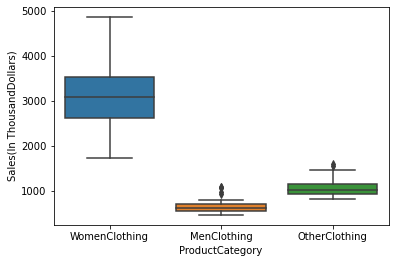

In [92]:
sns.boxplot(x='ProductCategory',y='Sales(In ThousandDollars)',data=train);

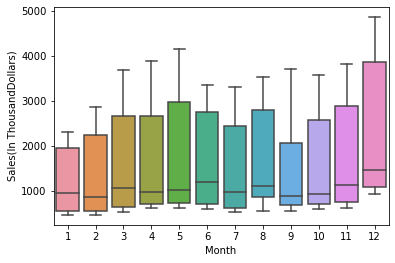

In [93]:
sns.boxplot(x='Month',y='Sales(In ThousandDollars)',data=train);

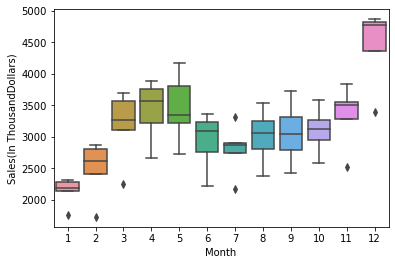

In [94]:
sns.boxplot(x='Month',y='Sales(In ThousandDollars)',data=train[train.ProductCategory=='WomenClothing']);

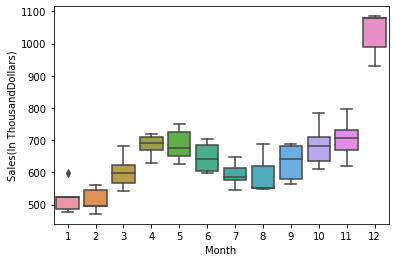

In [95]:
sns.boxplot(x='Month',y='Sales(In ThousandDollars)',data=train[train.ProductCategory=='MenClothing']);

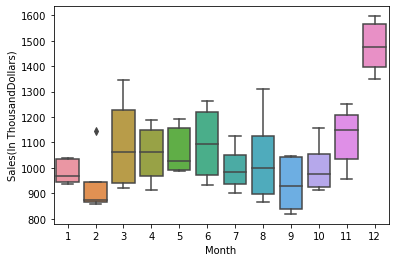

In [96]:
sns.boxplot(x='Month',y='Sales(In ThousandDollars)',data=train[train.ProductCategory=='OtherClothing']);

In [108]:
le = LabelEncoder()
full.ProductCategory= le.fit_transform(full[['ProductCategory']])

def sale_m(x):
    if x<595.1:
        return 'Low'
    elif x>=595.1 and x<684.55:
        return 'Medium'
    else :
        return 'High'

    
def sale_o(x):
    if x<996:
        return 'Low'
    elif x>=996 and x<1096.67:
        return 'Medium'
    else :
        return 'High'


def sale_f(x):
    if x<2898.40:
        return 'Low'
    elif x>=2898.40 and x<3358.38:
        return 'Medium'
    else :
        return 'High'

In [178]:
pca_full = PCA(n_components=.90)
pca_full_vec = pca_full.fit(full.iloc[:,3:],Y)
print(pca_full_vec.explained_variance_ratio_*100)
full_pca = DF(pca_full_vec.transform(full.iloc[:,3:]),columns=[f'PCA_{i}' for i in range(1,len(pca_full_vec.explained_variance_ratio_)+1)])
full_pca.head(10)

[30.77611047 21.39004191 12.39796993  8.96093817  5.98286972  4.11652485
  3.81702607  2.22946923  2.02539188]


,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9
0,-5.071950,2.605813,-1.068740,-1.599444,-0.529337,2.389843,1.769705,-2.052868,-1.057471
1,-5.071950,2.605813,-1.068740,-1.599444,-0.529337,2.389843,1.769705,-2.052868,-1.057471
2,-5.071950,2.605813,-1.068740,-1.599444,-0.529337,2.389843,1.769705,-2.052868,-1.057471
3,-5.344428,2.500183,-2.943234,0.375066,-0.021194,1.337036,1.888087,-1.743918,-0.760930
4,-5.344428,2.500183,-2.943234,0.375066,-0.021194,1.337036,1.888087,-1.743918,-0.760930
5,-5.344428,2.500183,-2.943234,0.375066,-0.021194,1.337036,1.888087,-1.743918,-0.760930
6,-3.466258,2.373455,-3.532958,-0.105757,-1.544035,2.812056,1.014376,0.208332,0.132557
7,-3.466258,2.373455,-3.532958,-0.105757,-1.544035,2.812056,1.014376,0.208332,0.132557
8,-3.466258,2.373455,-3.532958,-0.105757,-1.544035,2.812056,1.014376,0.208332,0.132557
9,-2.076444,3.441262,-0.837313,0.051459,1.357526,1.849109,0.356825,0.285838,-1.055882


In [120]:
sub = pd.read_csv('submission.csv',usecols=['Year','Month','ProductCategory'])
sub

,Year,Month,ProductCategory
0,2014,1,WomenClothing
1,2014,1,MenClothing
2,2014,1,OtherClothing
3,2014,2,WomenClothing
4,2014,2,MenClothing
5,2014,2,OtherClothing
6,2014,3,WomenClothing
7,2014,3,MenClothing
8,2014,3,OtherClothing
9,2014,4,WomenClothing


## Test data

In [138]:
tf = pd.merge(sub,pd.concat([test_2014[['Year','Month']],Xt],axis=1),on=['Year','Month'],copy=True)
tf.ProductCategory = le.transform(tf[['ProductCategory']])
tf

,Year,Month,ProductCategory,Dew Point avg (°C),Dew Point high (°C),Dew Point low (°C),Humidity (%) avg,Humidity (%) high,Humidity (%) low,Precip. (mm) sum,Sea Level Press. (hPa) avg,Sea Level Press. (hPa) high,Sea Level Press. (hPa) low,Temp avg (°C),Temp high (°C),Temp low (°C),Visibility (km) avg,Visibility (km) high,Visibility (km) low,Wind (km/h) avg,Wind (km/h) high,Wind (km/h) low,Monthly Nominal GDP Index (inMillion$),Monthly Real GDP Index (inMillion$),CPI,unemployment rate,CommercialBankInterestRateonCreditCardPlans,"Finance Rate on Personal Loans at Commercial Banks, 24 Month Loan",Earnings or wages in dollars per hour,Cotton Monthly Price - US cents per Pound(lbs),Change(in%),Average upland planted(million acres),Average upland harvested(million acres),yieldperharvested acre,Production (in 480-lb netweright in million bales),Mill use (in 480-lb netweright in million bales),Event,Exports
0,2014,1,2,-1.437695,-1.447865,-1.446911,0.036531,-0.081889,0.240603,-1.017188,-0.131662,0.465310,-1.166955,-1.563573,-1.539633,-1.593302,-0.138664,0.093398,-0.015522,0.511748,0.427982,-1.191501,-1.679873,-1.663968,-0.616149,1.214900,-0.056827,0.060122,-0.833216,0.755931,1.322932,-1.130231,-1.066457,0.775387,-1.056970,-1.140100,2.0,0.372401
1,2014,1,0,-1.437695,-1.447865,-1.446911,0.036531,-0.081889,0.240603,-1.017188,-0.131662,0.465310,-1.166955,-1.563573,-1.539633,-1.593302,-0.138664,0.093398,-0.015522,0.511748,0.427982,-1.191501,-1.679873,-1.663968,-0.616149,1.214900,-0.056827,0.060122,-0.833216,0.755931,1.322932,-1.130231,-1.066457,0.775387,-1.056970,-1.140100,2.0,0.372401
2,2014,1,1,-1.437695,-1.447865,-1.446911,0.036531,-0.081889,0.240603,-1.017188,-0.131662,0.465310,-1.166955,-1.563573,-1.539633,-1.593302,-0.138664,0.093398,-0.015522,0.511748,0.427982,-1.191501,-1.679873,-1.663968,-0.616149,1.214900,-0.056827,0.060122,-0.833216,0.755931,1.322932,-1.130231,-1.066457,0.775387,-1.056970,-1.140100,2.0,0.372401
3,2014,2,2,-1.267065,-1.332899,-1.226022,-0.111021,-0.109651,-0.117859,0.624068,0.225755,0.943416,-0.604742,-1.339898,-1.376830,-1.301535,-1.950704,-1.011538,-1.760701,0.659248,1.222903,1.090341,-1.420141,-1.357493,-1.177272,1.495262,-0.435672,-0.242429,0.845379,0.956147,1.195303,-1.130231,-1.066457,0.775387,-1.056970,-1.140100,2.0,0.372401
4,2014,2,0,-1.267065,-1.332899,-1.226022,-0.111021,-0.109651,-0.117859,0.624068,0.225755,0.943416,-0.604742,-1.339898,-1.376830,-1.301535,-1.950704,-1.011538,-1.760701,0.659248,1.222903,1.090341,-1.420141,-1.357493,-1.177272,1.495262,-0.435672,-0.242429,0.845379,0.956147,1.195303,-1.130231,-1.066457,0.775387,-1.056970,-1.140100,2.0,0.372401
5,2014,2,1,-1.267065,-1.332899,-1.226022,-0.111021,-0.109651,-0.117859,0.624068,0.225755,0.943416,-0.604742,-1.339898,-1.376830,-1.301535,-1.950704,-1.011538,-1.760701,0.659248,1.222903,1.090341,-1.420141,-1.357493,-1.177272,1.495262,-0.435672,-0.242429,0.845379,0.956147,1.195303,-1.130231,-1.066457,0.775387,-1.056970,-1.140100,2.0,0.372401
6,2014,3,2,-1.314261,-1.285850,-1.321802,-2.448652,-2.772347,-1.867636,-0.506924,-0.098970,0.460780,-0.641617,-1.065180,-0.987301,-1.140652,0.950735,0.830022,1.148356,1.268001,1.492688,1.618256,-1.131180,-1.130610,-0.251468,1.495262,-0.435672,-0.242429,0.261520,1.129798,1.123652,-1.130231,-1.066457,0.775387,-1.056970,-1.140100,0.0,1.087516
7,2014,3,0,-1.314261,-1.285850,-1.321802,-2.448652,-2.772347,-1.867636,-0.506924,-0.098970,0.460780,-0.641617,-1.065180,-0.987301,-1.140652,0.950735,0.830022,1.148356,1.268001,1.492688,1.618256,-1.131180,-1.130610,-0.251468,1.495262,-0.435672,-0.242429,0.261520,1.129798,1.123652,-1.130231,-1.066457,0.775387,-1.056970,-1.140100,0.0,1.087516
8,2014,3,1,-1.314261,-1.285850,-1.321802,-2.448652,-2.772347,-1.867636,-0.506924,-0.098970,0.460780,-0.641617,-1.065180,-0.987301,-1.140652,0.950735,0.830022,1.148356,1.268001,1.492688,1.618256,-1.131180,-1.130610,-0.251468,1.495262,-0.435672,-0.242429,0.261520,1.129798,1.123652,-1.130231,-1.066457,0.775387,-1.056970,-1.140100,0.0,1.087516
9,201

In [145]:
xgfull = XGBRegressor(n_estimators=200,max_leaves=4,random_state=2)
xgfull_m = xgfull.fit(full_pca,Y)

In [140]:
tf_pca = DF(pca_full_vec.transform(tf.iloc[:,2:]),columns=[f'PCA_{i}' for i in range(1,len(pca_full_vec.explained_variance_ratio_)+1)])
tf_pca.head()

,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10,PCA_11,PCA_12
0,-2.939783,2.353124,0.663574,-0.342240,-0.146224,0.680332,-1.678068,0.730244,-0.708591,1.197397,1.0,-0.520282
1,-2.939783,2.353124,0.663574,-0.342240,-0.146224,0.680332,-1.678068,0.730244,-0.708591,1.197397,-1.0,-0.520282
2,-2.939783,2.353124,0.663574,-0.342240,-0.146224,0.680332,-1.678068,0.730244,-0.708591,1.197397,0.0,-0.520282
3,-2.854914,1.552601,2.105931,-1.970282,-0.298863,2.015278,-2.186872,2.316475,-0.223178,0.910401,1.0,0.422336
4,-2.854914,1.552601,2.105931,-1.970282,-0.298863,2.015278,-2.186872,2.316475,-0.223178,0.910401,-1.0,0.422336


In [146]:
full_pred = xgfull_m.predict(tf_pca)

In [147]:
sam = DF({'Year':[*range(1,37)],'Sales(In ThousandDollars)':full_pred})
sam.to_csv('sam.csv',index=False)

In [148]:
from sklearn.ensemble import RandomForestRegressor

In [149]:
rf = RandomForestRegressor(n_estimators=100,random_state=1,oob_score=True)
rfm = rf.fit(full_pca,Y)
rfm.oob_score_

0.8983380970772056

In [153]:
rf_pred = rfm.predict(tf_pca)
sam = DF({'Year':[*range(1,37)],'Sales(In ThousandDollars)':rf_pred})
sam.to_csv('sam.csv',index=False)

In [158]:
rfb = RandomForestRegressor(n_estimators=100,random_state=1,oob_score=True)
rfbm = rfb.fit(full.iloc[:,:3],Y)
rfbm.oob_score_

0.9844345367787236

In [161]:
rfb_pred = rfbm.predict(tf.iloc[:,:3])
sam = DF({'Year':[*range(1,37)],'Sales(In ThousandDollars)':rfb_pred})
sam.to_csv('sam.csv',index=False)

In [171]:
#xgb = XGBRegressor(n_estimators=200,max_leaves=8,random_state=1)
xgbm = xgb.fit(pd.concat([full.iloc[:,:3],full_pca],axis=1),Y)
xgb_pred = xgbm.predict(pd.concat([tf.iloc[:,:3],tf_pca],axis=1))

In [170]:
np.sqrt(mse(Y,rfbm.predict(full.iloc[:,:3]))),np.sqrt(mse(Y,xgbm.predict(pd.concat([full.iloc[:,:3],full_pca],axis=1))))

(54.439324022254354, 0.0019278185921187175)

In [172]:
sam = DF({'Year':[*range(1,37)],'Sales(In ThousandDollars)':xgb_pred})
sam.to_csv('sam.csv',index=False)

In [179]:
tf_pca = DF(pca_full_vec.transform(tf.iloc[:,3:]),columns=[f'PCA_{i}' for i in range(1,len(pca_full_vec.explained_variance_ratio_)+1)])
tf_pca.head()

,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9
0,-2.939783,2.353124,0.663574,-0.342240,-0.146224,0.680332,-1.678068,0.730244,-0.708591
1,-2.939783,2.353124,0.663574,-0.342240,-0.146224,0.680332,-1.678068,0.730244,-0.708591
2,-2.939783,2.353124,0.663574,-0.342240,-0.146224,0.680332,-1.678068,0.730244,-0.708591
3,-2.854914,1.552601,2.105931,-1.970282,-0.298863,2.015278,-2.186872,2.316475,-0.223178
4,-2.854914,1.552601,2.105931,-1.970282,-0.298863,2.015278,-2.186872,2.316475,-0.223178


In [180]:
rfb = RandomForestRegressor(n_estimators=200,random_state=1,oob_score=True)
rfbm = rfb.fit(pd.concat([full.iloc[:,:3],full_pca],axis=1),Y)
rfb_pred =  rfbm.predict(pd.concat([tf.iloc[:,:3],tf_pca],axis=1))
sam = DF({'Year':[*range(1,37)],'Sales(In ThousandDollars)':rfb_pred})
sam.to_csv('sam.csv',index=False)
rfbm.oob_score_

0.95861568343989